In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import meshio
from pathlib import Path


import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random
import optax
from tqdm.auto import tqdm
from typing import Callable
import pickle
import equinox as eqx

import os

from triangular_transport.flows.flow_trainer import (
    NNTrainer,
)

from triangular_transport.flows.interpolants import (
    linear_interpolant,
    linear_interpolant_der,
    trig_interpolant,
    trig_interpolant_der,
    sigmoid_interpolant,
    sigmoid_interpolant_der,
)
from triangular_transport.flows.loss_functions import vec_field_loss
from triangular_transport.networks.flow_networks import MLP, MLP_Triangular
from triangular_transport.flows.methods.utils import UnitGaussianNormalizer
from triangular_transport.flows.dataloaders import gaussian_reference_sampler

import json
import h5py

import argparse

plt.style.use("ggplot")

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update("jax_default_device", jax.devices()[1])

In [2]:
def read_data_h5(path="data.h5"):
    with h5py.File(path, "r") as f:
        targets = f["/target"][...]
        data = f["/data"][...]
    return targets, data

In [3]:
with open("poisson.yaml") as fid:
    inargs = yaml.full_load(fid)

utrue = np.load("training_dataset/true_param_grid.npy")
ytrue = np.load("training_dataset/true_state_grid.npy")
targets, yobs = read_data_h5()

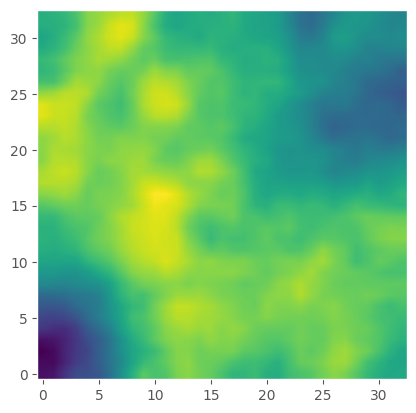

In [4]:
plt.imshow(utrue, origin="lower", interpolation="bilinear")
plt.grid(False)

In [15]:
nsamples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]

hmala_samps = np.load("training_dataset/chain_00/hmala_samples_grid.npy").reshape(nsamples, 33, 33)
hmala_mean = np.mean(hmala_samps, axis=0)
hmala_var = np.var(hmala_samps, axis=0)

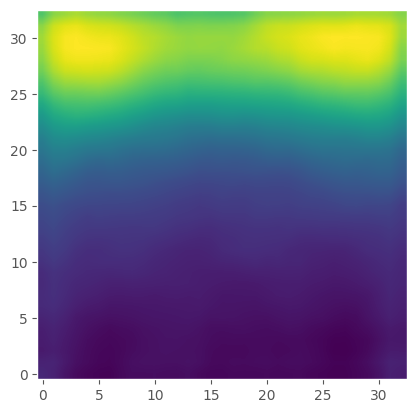

In [16]:
plt.imshow(hmala_var, origin="lower", interpolation="bilinear")
plt.grid(False)

In [7]:
train_dim = 50000
nx = ny = 33
flat_length = nx * ny
ys = (np.load("training_dataset/solutions_grid.npy"))[:train_dim]
us = (np.load("training_dataset/parameters.npy"))[:train_dim, :].reshape(train_dim, flat_length)

us_ref = us.copy()
np.random.shuffle(us_ref)

us_test = (np.load("training_dataset/parameters.npy"))[train_dim:train_dim + 20000, :].reshape(20000, flat_length)
np.random.shuffle(us_test)

ys_normalizer = UnitGaussianNormalizer(ys)
ys_normalized = ys_normalizer.encode()

2025-10-13 10:31:26.677206: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [8]:
mean_us = us.mean(axis=0)
X = us - mean_us

U, S, Vt = np.linalg.svd(us / (np.sqrt(train_dim - 1)), full_matrices=False)
V = Vt.T

expl_var = (S**2) / (S**2).sum()
k = np.searchsorted(np.cumsum(expl_var), 0.98) + 1
# k = 30

V = V[:, :k]
S = S[:k]

alpha = 0.1


def pca_encode(b):
    # whitened coeffs z
    return (b - mean_us) @ V / S


def pca_decode(z):
    # undo whitening
    return mean_us + (z * S) @ V.T

In [9]:
us_pca = pca_encode(us)
us_ref_pca = pca_encode(us_ref)
us_test_pca = pca_encode(us_test)

target_data = jnp.hstack([ys_normalized, us_pca])
ref_data = jnp.hstack([ys_normalized, us_ref_pca])

In [22]:
key = random.PRNGKey(seed=42)
key1, key2 = random.split(key=key, num=2)
batch_size = 128
steps = 50000
print_every = 5000
yu_dimension = (100, k.item())
dim = yu_dimension[0] + yu_dimension[1]
hidden_layer_list = [512] * 4
model = MLP(
    key=key2,
    dim=dim,
    time_varying=True,
    w=hidden_layer_list,
    num_layers=len(hidden_layer_list) + 1,
    activation_fn=jax.nn.gelu,  # GeLU worked well
)
# schedule = optax.linear_schedule(
#     init_value=1e-3,          # Starting learning rate
#     end_value=3e-4,           # Final learning rate
#     transition_steps=2000     # Number of steps over which to linearly increase
# )
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=3e-4,
    warmup_steps=2_000,
    decay_steps=steps,
    end_value=1e-5,
)
# lr=1e-9
optimizer = optax.adamw(schedule)
optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adamw(schedule))
interpolant = trig_interpolant
interpolant_der = trig_interpolant_der
interpolant_args = {"t": None, "x1": None, "x0": None}

In [23]:
trainer = NNTrainer(
    target_density=None,
    model=model,
    optimizer=optimizer,
    interpolant=interpolant,
    interpolant_der=interpolant_der,
    reference_sampler=gaussian_reference_sampler,
    loss=vec_field_loss,
    interpolant_args=interpolant_args,
    yu_dimension=yu_dimension,
)
trainer.train(
    train_data=target_data,
    train_dim=train_dim,
    batch_size=batch_size,
    steps=steps,
    x0_data=ref_data,
);

Training neural network


  0%|          | 0/50000 [00:00<?, ?it/s]

step = 0, train_loss = 0.20072129368782043
step = 5000, train_loss = -89.18380737304688
step = 10000, train_loss = -97.69137573242188
step = 15000, train_loss = -94.32118225097656
step = 20000, train_loss = -114.87137603759766
step = 25000, train_loss = -120.28187561035156
step = 30000, train_loss = -105.62410736083984
step = 35000, train_loss = -120.75747680664062
step = 40000, train_loss = -98.55682373046875
step = 45000, train_loss = -101.37881469726562
step = 49999, train_loss = -104.97435760498047


In [24]:
no_samples = inargs["MCMC"]["nsamples"] - inargs["MCMC"]["burnin"]
ytrue_flat = yobs.copy()
ytrue_flat_normalized = ys_normalizer.encode(ytrue_flat)
ys_test_normalized = jnp.full(
    (no_samples, ytrue_flat_normalized.shape[0]), ytrue_flat_normalized
)
x0_test = jnp.hstack([ys_test_normalized, us_test_pca])
# x0_test = jnp.hstack([ys_test_normalized, us_test])

cond_values = [tuple(ytrue_flat_normalized)]
cond_samples = trainer.conditional_sample(
    cond_values=cond_values, x0_cond=x0_test, nsamples=20000
)
all_samples = cond_samples[0][0]

u_samples = all_samples[:, yu_dimension[0] :]
u_samples = pca_decode(u_samples)
u_samples = u_samples.reshape(no_samples, nx, ny)
u_means = jnp.mean(u_samples, axis=0)
u_var = jnp.var(u_samples, axis=0)

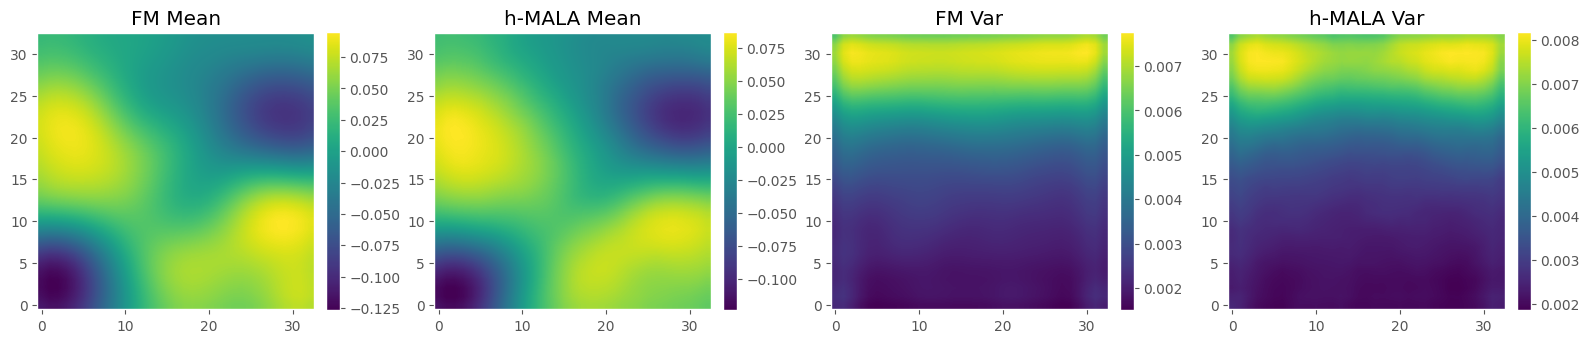

: 

In [ ]:
layer_idx = 0
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

im0 = ax[0].imshow(u_means, origin="lower", interpolation="bilinear")
ax[0].set_title("FM Mean")
ax[0].grid(False)
fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(
    hmala_mean, origin="lower", interpolation="bilinear"
)
ax[1].set_title("h-MALA Mean")
ax[1].grid(False)
fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(u_var, origin="lower", interpolation="bilinear")
ax[2].set_title("FM Var")
ax[2].grid(False)
fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(hmala_var, origin="lower", interpolation="bilinear")
ax[3].set_title("h-MALA Var")
ax[3].grid(False)
fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()